## Importing Necessary Modules

In [24]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os
import random
from tqdm.auto import tqdm
import time

In [2]:
nlp = spacy.load("en_core_sci_md")

## Loading the Dataset

In [2]:
data_dir = r'C:\Users\vmurc\Desktop\VA Docs\Projects\csv_usa_100k' + '\\' #Establish location of data
print('The data is located at:')
print(data_dir, '\n')
data_list = os.listdir(data_dir) #List the data files
print('The data files are:')
print(data_list)

The data is located at:
C:\Users\vmurc\Desktop\VA Docs\Projects\csv_usa_100k\ 

The data files are:
['allergies.csv', 'careplans.csv', 'conditions.csv', 'devices.csv', 'encounters.csv', 'imaging_studies.csv', 'immunizations.csv', 'medications.csv', 'observations.csv', 'organizations.csv', 'patients.csv', 'payers.csv', 'payer_transitions.csv', 'procedures.csv', 'providers.csv', 'supplies.csv']


In [3]:
#Add data path to beginning of each element of list so that I can easily access them later
def prepend(list, str):
    str += '% s'
    new_list = [str % i for i in list]
    return new_list
new_list = prepend(data_list,data_dir)
new_list

['C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\allergies.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\careplans.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\conditions.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\devices.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\encounters.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\imaging_studies.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\immunizations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\medications.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\observations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\organizations.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\patients.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\csv_usa_100k\\payers.csv',
 'C:\\Users\\vmurc\\Desktop\\VA Docs\\Projects\\c

## Create Dataframes

In [61]:
#I'm going to use this to quickly check the contents and columns of the various csv files
#I'll use this to determine whether I should keep or drop a column or even an entire csv file from my analysis
cols = list(pd.read_csv(new_list[5], nrows =0)) #Only read the column headers
print(cols)
tdf = pd.read_csv(new_list[5], nrows =5) #Only read the first five rows for quick check of contents
tdf

['Id', 'DATE', 'PATIENT', 'ENCOUNTER', 'BODYSITE_CODE', 'BODYSITE_DESCRIPTION', 'MODALITY_CODE', 'MODALITY_DESCRIPTION', 'SOP_CODE', 'SOP_DESCRIPTION']


,Id,DATE,PATIENT,ENCOUNTER,BODYSITE_CODE,BODYSITE_DESCRIPTION,MODALITY_CODE,MODALITY_DESCRIPTION,SOP_CODE,SOP_DESCRIPTION
0,d0527445-2bd4-414d-a963-5a0fb0ff4f2a,1981-07-09T12:17:54Z,9b95290a-6195-4a40-b5f7-096ae727e793,df36b9f7-bd58-45c8-a140-421eca277168,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
1,8b37bedd-395d-4f76-9382-a6adcda99cd9,1967-01-14T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,495a955f-5913-4f2a-b51b-8b4282237951,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
2,ca5a7852-4482-4d9d-9cb9-91299292983a,1978-01-21T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,862e8974-4845-45a1-a152-acbc1dc41f5b,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
3,c4be7a11-67b6-4e87-b1f5-dab7ced73365,1994-10-29T11:19:50Z,3589d3e0-1b87-4ef6-84f1-6be843786260,0863769d-5197-4ec0-9499-08dd3d065c85,51299004,Clavicle,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage
4,5331ed0b-c7e2-45da-b510-caacd4e1c705,1964-04-05T00:48:47Z,88dab48e-5ff5-42af-8eab-4a3c37574952,d5e0574c-99e5-4150-9e21-d9656f72f258,51185008,Chest,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage


In [54]:
omit_cols = ['START','STOP','ENCOUNTER','Id','BASE_COST','PAYER_COVERAGE','DATE','TYPE','DEATHDATE', 
             'SSN', 'DRIVERS', 'PASSPORT', 'MAIDEN','ADDRESS','FIRST', 'LAST', 'SUFFIX','START_YEAR', 
             'END_YEAR', 'PAYER','BASE_COST','QUANTITY',]

In [16]:
new_cols = [s + '_al' for s in cols]
new_cols

['DATE_al',
 'PATIENT_al',
 'ENCOUNTER_al',
 'CODE_al',
 'DESCRIPTION_al',
 'VALUE_al',
 'UNITS_al',
 'TYPE_al']

In [32]:
chunk_list = [] # used for storing dataframes

chunks = pd.read_csv(new_list[8], chunksize=100000,usecols =[i for i in cols if i not in omit_cols],nrows=1e9)

#process each chunk and append them to the list
for chunk in chunks:
    chunk_list.append(chunk)
    
# concat all the dfs in the list into a single dataframe 
df_observations = pd.concat(chunk_list)

In [36]:
df_observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208292927 entries, 0 to 208292926
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   PATIENT      object
 1   CODE         object
 2   DESCRIPTION  object
 3   VALUE        object
 4   UNITS        object
dtypes: object(5)
memory usage: 7.8+ GB


In [35]:
df_observations

,PATIENT,CODE,DESCRIPTION,VALUE,UNITS
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,8302-2,Body Height,49.3,cm
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score}
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,29463-7,Body Weight,3.1,kg
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,77606-2,Weight-for-length Per age and sex,34.8,%
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,9843-4,Head Occipital-frontal circumference,32.9,cm
...,...,...,...,...,...
208292922,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292923,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292924,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}
208292925,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,QOLS,QOLS,0.9,{score}


In [51]:
ddf = df_observations[df_observations['PATIENT'] == df_observations['PATIENT'][0]]
ddf.head(20)

,PATIENT,CODE,DESCRIPTION,VALUE,UNITS
0,55f07b08-3c77-42cc-8514-4c0a37c4039e,8302-2,Body Height,49.3,cm
1,55f07b08-3c77-42cc-8514-4c0a37c4039e,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score}
2,55f07b08-3c77-42cc-8514-4c0a37c4039e,29463-7,Body Weight,3.1,kg
3,55f07b08-3c77-42cc-8514-4c0a37c4039e,77606-2,Weight-for-length Per age and sex,34.8,%
4,55f07b08-3c77-42cc-8514-4c0a37c4039e,9843-4,Head Occipital-frontal circumference,32.9,cm
5,55f07b08-3c77-42cc-8514-4c0a37c4039e,8462-4,Diastolic Blood Pressure,71.0,mm[Hg]
6,55f07b08-3c77-42cc-8514-4c0a37c4039e,8480-6,Systolic Blood Pressure,117.0,mm[Hg]
7,55f07b08-3c77-42cc-8514-4c0a37c4039e,8867-4,Heart rate,78.0,/min
8,55f07b08-3c77-42cc-8514-4c0a37c4039e,9279-1,Respiratory rate,13.0,/min
9,55f07b08-3c77-42cc-8514-4c0a37c4039e,6690-2,Leukocytes [#/volume] in Blood by Automated count,6.4,10*3/uL


In [4]:
#List of columns to omit during loading
omit_cols = ['START','STOP','ENCOUNTER','Id','BASE_COST','PAYER_COVERAGE','DATE']
#Create the dataframes for each of the .csv files from the Synthetic Suicide Prevention Dataset with SDoH
df_allergies         = pd.read_csv(new_list[0] , usecols =[i for i in cols if i not in omit_cols])
df_careplans         = pd.read_csv(new_list[1] , usecols =[i for i in cols if i not in omit_cols])
df_conditions        = pd.read_csv(new_list[2] , usecols =[i for i in cols if i not in omit_cols])
df_devices           = pd.read_csv(new_list[3] , usecols =[i for i in cols if i not in omit_cols])
#df_encounters        = pd.read_csv(new_list[4] , usecols =[i for i in cols if i not in omit_cols])
df_imaging_studies   = pd.read_csv(new_list[5] , usecols =[i for i in cols if i not in omit_cols])
df_immunizations     = pd.read_csv(new_list[6] , usecols =[i for i in cols if i not in omit_cols])
df_medications       = pd.read_csv(new_list[7] , usecols =[i for i in cols if i not in omit_cols])
#df_observations      = pd.read_csv(new_list[8] ,nrows=10500000, usecols =[i for i in cols if i not in omit_cols])
df_organizations     = pd.read_csv(new_list[9] ,on_bad_lines='skip', usecols =[i for i in cols if i not in omit_cols)
df_patients          = pd.read_csv(new_list[10],engine='python', usecols =[i for i in cols if i not in omit_cols)
#df_payers            = pd.read_csv(new_list[11], usecols =[i for i in cols if i not in omit_cols])
#df_payer_transitions = pd.read_csv(new_list[12], usecols =[i for i in cols if i not in omit_cols])
df_procedures        = pd.read_csv(new_list[13], usecols =[i for i in cols if i not in omit_cols])
#df_providers         = pd.read_csv(new_list[14], usecols =[i for i in cols if i not in omit_cols])
df_supplies          = pd.read_csv(new_list[15], usecols =[i for i in cols if i not in omit_cols])

## EDA

In [36]:
#Cursory view of dataframe
df_allergies

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1952-06-01,1969-02-21,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,300916003,Latex allergy
1,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,419474003,Allergy to mould
2,1952-06-01,NaN,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,232347008,Dander (animal) allergy
3,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,418689008,Allergy to grass pollen
4,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,419263009,Allergy to tree pollen
...,...,...,...,...,...,...
42575,1966-02-24,1993-07-09,12b84202-69a2-4d3a-9b7c-aede708ed902,16884ab4-5b99-4d7c-9f15-95ede09a28ae,419263009,Allergy to tree pollen
42576,1966-02-24,1982-03-25,12b84202-69a2-4d3a-9b7c-aede708ed902,16884ab4-5b99-4d7c-9f15-95ede09a28ae,425525006,Allergy to dairy product
42577,1966-02-24,NaN,12b84202-69a2-4d3a-9b7c-aede708ed902,16884ab4-5b99-4d7c-9f15-95ede09a28ae,300913006,Shellfish allergy
42578,1966-02-24,NaN,12b84202-69a2-4d3a-9b7c-aede708ed902,16884ab4-5b99-4d7c-9f15-95ede09a28ae,91934008,Allergy to nut


In [38]:
#Get basic info of contents
df_allergies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42580 entries, 0 to 42579
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   START        42580 non-null  object
 1   STOP         17090 non-null  object
 2   PATIENT      42580 non-null  object
 3   ENCOUNTER    42580 non-null  object
 4   CODE         42580 non-null  int64 
 5   DESCRIPTION  42580 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.9+ MB


In [37]:
#Find unique patients and unique descriptions
print(df_allergies['PATIENT'].nunique())
print(df_allergies['DESCRIPTION'].nunique())

10975
15


In [64]:
#Check to see how many allergies a given patient has
patient = df_allergies['PATIENT'][0]
patient_df = df_allergies[df_allergies['PATIENT'] == patient] 
patient_df

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1952-06-01,1969-02-21,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,300916003,Latex allergy
1,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,419474003,Allergy to mould
2,1952-06-01,NaN,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,232347008,Dander (animal) allergy
3,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,418689008,Allergy to grass pollen
4,1952-06-01,1993-07-07,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,419263009,Allergy to tree pollen
5,1952-06-01,NaN,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,425525006,Allergy to dairy product
6,1952-06-01,1969-02-21,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,91930004,Allergy to eggs
7,1952-06-01,NaN,bb415c7b-8428-43ea-954e-de034d98d43e,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,300913006,Shellfish allergy


Hmmm, maybe I can consolidate the data for each patient into a single row instead? Collect all instances of START, STOP, CODE, and DESCRIPTION for a given patient and place them into lists within a single column for each.

In [86]:
df_careplans

,Id,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,REASONCODE,REASONDESCRIPTION
0,b81999cf-f812-4bfb-b5a9-482a22ba02f3,1975-07-15,NaN,55f07b08-3c77-42cc-8514-4c0a37c4039e,e37dace6-8a53-4ff3-b990-8c6a51950d31,443402002,Lifestyle education regarding hypertension,59621000.0,Hypertension
1,4bf6ed6f-0a5e-4802-84d2-3f8ed5b91fb4,1993-11-10,1994-11-01,55f07b08-3c77-42cc-8514-4c0a37c4039e,5ac8a605-11d5-49a1-a7f4-ba06c5a9ed48,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
2,b29e7361-4369-4811-aee6-cd2d80d77f20,2000-12-30,2001-01-06,55f07b08-3c77-42cc-8514-4c0a37c4039e,428f1e32-3a70-401d-a1ef-a7f7fe62b262,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
3,0446d6c8-020d-4320-ae01-fc70faa62466,2001-07-07,2001-07-14,55f07b08-3c77-42cc-8514-4c0a37c4039e,b8fc3ec3-10a5-41da-81dc-ae008ac05a38,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
4,a20006ad-67b3-456c-a95e-5f107ad3da4d,2001-07-17,NaN,55f07b08-3c77-42cc-8514-4c0a37c4039e,c685dd08-ee92-466b-b960-58b948a74813,698360004,Diabetes self management plan,15777000.0,Prediabetes
...,...,...,...,...,...,...,...,...,...
1290305,609b5dd7-d828-46de-8f18-99553456a3fe,1993-06-26,1993-07-03,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,feba46f9-a8f7-4e0b-8b34-1dc98467b0ce,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
1290306,7ee337e1-879d-4d11-b01b-b93be73aaff2,1999-04-19,NaN,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,9dc3f258-cd68-462b-b941-406136745539,736252007,Cancer care plan,126906006.0,Neoplasm of prostate
1290307,efa10c9a-c79d-4b69-b32d-47d1f62305b5,2002-07-23,2002-08-22,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,07825344-17a3-4d2f-ae00-489af92c5aa2,385691007,Fracture care,58150001.0,Fracture of clavicle
1290308,167152f5-b6f7-49fb-b828-f3e4834b11a9,2020-03-11,2020-03-11,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,736376001,Infectious disease care plan (record artifact),840544004.0,Suspected COVID-19


In [94]:
df_careplans[df_careplans['PATIENT'] == condensed_allergy_df['PATIENT'][0]]

,Id,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,REASONCODE,REASONDESCRIPTION
228057,524c5afd-0a40-415c-807d-e8a2623b310f,1976-05-19,NaN,bdcc1813-e534-4ad0-a287-5d02029c947f,2c0013b7-8218-4cd5-b222-5f28cea544b9,384758001,Self-care interventions (procedure),NaN,NaN
228058,a24ad64c-0457-495a-b446-abdd237bd762,1977-06-10,1977-09-08,bdcc1813-e534-4ad0-a287-5d02029c947f,8b72812b-962e-4eb3-8290-5dbc98434dc6,385691007,Fracture care,65966004.0,Fracture of forearm
228059,dafe5c2b-3af4-4f96-a3e5-0e4c9715be24,1978-01-13,1993-05-24,bdcc1813-e534-4ad0-a287-5d02029c947f,57ab8e07-d7f1-46e1-94c6-de0bd053f39c,711282006,Skin condition care,24079001.0,Atopic dermatitis
228060,0b8371d0-3834-435a-b13c-5f68d92f5e4d,1978-08-26,NaN,bdcc1813-e534-4ad0-a287-5d02029c947f,80d0e2aa-b32f-4487-892f-2913c90fd8c0,699728000,Asthma self management,233678006.0,Childhood asthma
228061,3e93644f-f4c3-4b0d-85e5-b2b05e2a6b8a,1982-01-17,1982-08-11,bdcc1813-e534-4ad0-a287-5d02029c947f,73df029f-1ca1-47ff-8ce2-93ce0c2a6ef9,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
228062,a52af459-3685-4e67-8163-0abaf010d40a,1990-01-03,1993-07-07,bdcc1813-e534-4ad0-a287-5d02029c947f,e52aaa9e-eefe-4fd0-8e7d-8cfb6b958eb0,170836005,Allergic disorder monitoring,NaN,NaN
228063,a98554e7-2537-428f-aa8e-f87d5d42284b,2006-12-27,NaN,bdcc1813-e534-4ad0-a287-5d02029c947f,ecbf13f1-d7c9-460a-9b56-2260b9bdc4a8,698360004,Diabetes self management plan,15777000.0,Prediabetes
228064,e7b5bbad-7a3e-43bf-9f85-3913758110a2,2014-08-25,2014-11-23,bdcc1813-e534-4ad0-a287-5d02029c947f,40dde20d-e262-4293-b953-06aeb81aa371,385691007,Fracture care,58150001.0,Fracture of clavicle
228065,baa5c8d2-ce43-4c0f-9188-7cb04b28eca5,2020-02-29,2020-02-29,bdcc1813-e534-4ad0-a287-5d02029c947f,3cc48c20-6d5b-401b-a87b-27143cf01847,736376001,Infectious disease care plan (record artifact),840544004.0,Suspected COVID-19
228066,f4a685bf-fa12-41ed-b36e-8dbe15ee970f,2020-02-29,2020-03-18,bdcc1813-e534-4ad0-a287-5d02029c947f,3cc48c20-6d5b-401b-a87b-27143cf01847,736376001,Infectious disease care plan (record artifact),840539006.0,COVID-19


In [98]:
#list of dataframes for batch processing
data_frames = [
    df_allergies, df_careplans, df_conditions, df_devices, df_encounters,df_imaging_studies,
    df_immunizations,df_medications, df_observations, df_organizations, df_patients, df_payers, df_payer_transitions,
    df_procedures, df_providers, df_supplies 
]

In [ ]:
def restructure_dfs(ref_df,source_df,nPatients):
    """
    This function combines the observations for a patient in the Synthetic Veteran Suicide Dataset into a 
    single row in a new dataframe. Doing this should help with the NLP processing later.
    
    Parameters
    ----------
    nPatients : int,  How many patients to process?
    ref_df    : df,   Dataframe containing restructured patient data (should be the first dataframe that was 
                      restructured)
    source_df : df,   Dataframe that contains information to be restructured
    ----------
    """
    # Create empty patient dataframe
    columns = source_df.columns
    temp_df = pd.DataFrame(index=np.arange(nPatients),columns=columns)    
    
    for i in tqdm(range(ref_df.shape[0])):
        patient = ref_df['PATIENT'][i] #Patient ID    
        #dummy_df   = source_df[source_df['PATIENT'] == patient]
        
        #Programatically populate the dataframe by first making lists out of the columns and then inserting
        #these lists into cells in the resulting dataframe
        for k,col in enumerate(columns):
            if col == 'PATIENT':
                temp_df.at[i, 'PATIENT'] = patient    
            else:
                temp_df.at[i, col] = source_df[col].tolist()
                
    return temp_df

def make_patient_df(nPatients,df,df_list,init_rand=False):
    """
    This function combines the observations for a patient in the Synthetic Veteran Suicide Dataset into a 
    single row in a new dataframe. Doing this should help with the NLP processing later.
    
    Parameters
    ----------
    nPatients : int,  How many patients to process?
    df        : df,   Dataframe containing patient data
    df_list   : list, list of all dataframes in dataset
    init_rand : bool, Use random values to choose patients? Defaults to False so only first 10 patients are selected
    ----------
    """
    #Determine number of unique patients in dataframe
    unique_patients = df['PATIENT'].nunique()
    
    #Initialize iterators and patient index
    i = 0; j = random.randrange(unique_patients)
    
    #Initialize index array
    index_list = []
    
    # Create empty patient dataframe
    columns = df.columns
    new_df  = pd.DataFrame(index=np.arange(nPatients),columns=columns)
    
    #Make list of restructured dataframes
    rs_df_list = []
    
    for i in range(nPatients):
        
        #Select a random patient from the existing dataframe (random sample)
        if init_rand == True:
            j = random.randrange(unique_patients)                
        else:
            j = i 
        
        #Check that patient id has not already been added
        if j not in index_list:
            index_list.append(j)
        else:
            while j in index_list:
                j = random.randrange(unique_patients) 
            index_list.append(j)
        
        #Subset the dataframe so as to only show the results associated with a given patient
        patient    = df['PATIENT'][j] #Patient ID
        dummy_df   = df[df['PATIENT'] == patient]
        
        #Programatically populate the dataframe by first making lists out of the columns and then inserting
        #these lists into cells in the resulting dataframe
        for k,col in enumerate(cols):
            if col == 'PATIENT':
                new_df.at[i, 'PATIENT'] = patient    
            else:
                new_df.at[i, col] = dummy_df[col].tolist()
   
    #Append the restructured dataframe to the list of dfs
    rs_df_list.append(new_df)
    
    #Reprocess the remaining dataframes and add them to the list
    for m,cdf in tqdm(enumerate(df_list[1:])):
        temp_df = restructure_dfs(new_df,cdf,nPatients)
        rs_df_list.append(temp_df)
        if m == 7:
            break
            
    print('These are the indices for the patient IDs used to generate the dataframe below. \n',index_list)

    return new_df,index_list,rs_df_list  

condensed_allergy_df,index_list,rs_df_list  = make_patient_df(3, df_allergies,data_frames, init_rand=True)

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.47it/s]
1it [00:00,  4.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]
2it [00:00,  2.94it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1499.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:0

In [ ]:
#Need to rename the columns since there are quite a few duplicate names that are unique to each .csv
#In particular CODE, DESCRIPTION, ENCOUNTER, START, STOP
df.rename(columns={"A": "a", "B": "c"})

In [116]:
len(rs_df_list)

4

In [129]:
rs_df_list[2]

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",331bab68-dd6e-4e20-b8dd-4edb0cd86457,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."
1,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",b6d8ae21-da36-4221-afce-6f0d0ba7c801,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."
2,"[1957-09-20, 1957-12-17, 1961-07-16, 1962-01-2...","[1957-10-01, 1958-01-28, 1961-07-24, 1962-02-0...",42529e44-0117-46ea-b795-74d37aa93783,"[6f777c09-97ea-4415-b745-76ab5a7568ac, 3fc5380...","[195662009, 65363002, 43878008, 195662009, 195...","[Acute viral pharyngitis (disorder), Otitis me..."


In [72]:
condensed_allergy_df,index_list  = make_patient_df(10, df_allergies, init_rand=True)
condensed_allergy_df

These are the indices for the patient IDs used to generate the dataframe below. 
 [7288, 8413, 3434, 3893, 5010, 2709, 6826, 8505, 1083, 7337]


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,"[1976-05-28, 1976-05-28, 1976-05-28, 1976-05-2...","[1993-01-25, 1993-07-07, 1993-07-07, 1993-07-0...",bdcc1813-e534-4ad0-a287-5d02029c947f,"[04d56a05-5756-459f-bb6a-b465bccc6e94, 04d56a0...","[300916003, 419474003, 232347008, 419263009, 3...","[Latex allergy, Allergy to mould, Dander (anim..."
1,"[1983-12-17, 1983-12-17, 1983-12-17, 1983-12-1...","[1999-01-20, 1999-01-20, 1999-01-20, nan, 1999...",1c21c496-75be-44e9-a754-9412322e19d1,"[a79382ed-5ae5-4a6a-ab77-7a3aeef1a5e7, a79382e...","[419474003, 232350006, 232347008, 418689008, 4...","[Allergy to mould, House dust mite allergy, Da..."
2,"[1952-01-12, 1952-01-12, 1952-01-12, 1952-01-1...","[1968-02-07, nan, 1993-07-08, 1993-07-08, 1993...",3e155d5e-cb9f-4ee2-8121-0c9dd4fffaf7,"[fc0b7ad8-5496-4ef4-9c6f-5af1e0b32a97, fc0b7ad...","[300916003, 424213003, 419474003, 232350006, 2...","[Latex allergy, Allergy to bee venom, Allergy ..."
3,"[1959-10-03, 1959-10-03, 1959-10-03, 1959-10-0...","[1977-03-20, nan, 1993-07-06, 1993-07-06, nan,...",6aa9b177-2a56-478d-a3cd-9ed5a13eee9c,"[c72ab227-dac9-40c3-87d8-396be9950101, c72ab22...","[300916003, 424213003, 419474003, 232350006, 2...","[Latex allergy, Allergy to bee venom, Allergy ..."
4,"[1991-08-31, 1991-08-31]","[nan, nan]",0e4f152f-0aa7-4aa9-bb3a-062b760f7bb0,"[56bc5a8a-51eb-44fc-a888-ba819483eb96, 56bc5a8...","[232347008, 417532002]","[Dander (animal) allergy, Allergy to fish]"
5,"[1957-02-02, 1957-02-02]","[nan, nan]",1026f6de-2522-4cc2-b239-edbe96ec9982,"[9e31c1d3-145d-4ddf-9b81-7b9f8f0d2f8c, 9e31c1d...","[419474003, 91935009]","[Allergy to mould, Allergy to peanuts]"
6,"[1959-01-31, 1959-01-31, 1959-01-31, 1959-01-3...","[nan, nan, nan, nan, nan, nan]",65547d69-035d-45c3-8826-5291ebb61198,"[20c4bc2e-0046-49dc-9ed3-c9de17ace0e5, 20c4bc2...","[300916003, 419474003, 232350006, 232347008, 4...","[Latex allergy, Allergy to mould, House dust m..."
7,"[1950-06-04, 1950-06-04, 1950-06-04, 1950-06-0...","[nan, nan, nan, nan, nan, nan, nan]",d6a5fd92-acb6-4a11-9872-6ef3d2a96f64,"[f52461d0-2a09-4c67-ae9a-deaff530c1c6, f52461d...","[424213003, 419474003, 232350006, 232347008, 4...","[Allergy to bee venom, Allergy to mould, House..."
8,"[1984-06-02, 1984-06-02, 1984-06-02, 1984-06-0...","[2000-06-25, nan, nan, 1999-08-01, 1999-08-01,...",24323ab9-008b-4fc1-a789-ecf83f7679f3,"[63c68862-3087-4a24-adac-66239094e75d, 63c6886...","[300916003, 424213003, 419474003, 232347008, 4...","[Latex allergy, Allergy to bee venom, Allergy ..."
9,[1933-11-30],[1951-10-16],95099a3b-4326-427a-9adf-c8417bd130df,[564f8602-ebd4-4e3a-b313-a532cb3c42b1],[91930004],[Allergy to eggs]


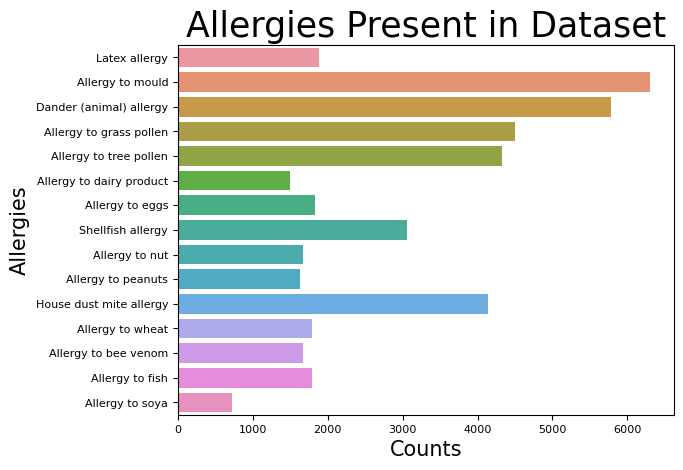

In [48]:
#Visualize allergy distribution
b = sns.countplot(data=df_allergies,y='DESCRIPTION')
b.axes.set_title("Allergies Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Allergies",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

In [38]:
df_careplans

,Id,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,REASONCODE,REASONDESCRIPTION
0,b81999cf-f812-4bfb-b5a9-482a22ba02f3,1975-07-15,NaN,55f07b08-3c77-42cc-8514-4c0a37c4039e,e37dace6-8a53-4ff3-b990-8c6a51950d31,443402002,Lifestyle education regarding hypertension,59621000.0,Hypertension
1,4bf6ed6f-0a5e-4802-84d2-3f8ed5b91fb4,1993-11-10,1994-11-01,55f07b08-3c77-42cc-8514-4c0a37c4039e,5ac8a605-11d5-49a1-a7f4-ba06c5a9ed48,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
2,b29e7361-4369-4811-aee6-cd2d80d77f20,2000-12-30,2001-01-06,55f07b08-3c77-42cc-8514-4c0a37c4039e,428f1e32-3a70-401d-a1ef-a7f7fe62b262,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
3,0446d6c8-020d-4320-ae01-fc70faa62466,2001-07-07,2001-07-14,55f07b08-3c77-42cc-8514-4c0a37c4039e,b8fc3ec3-10a5-41da-81dc-ae008ac05a38,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
4,a20006ad-67b3-456c-a95e-5f107ad3da4d,2001-07-17,NaN,55f07b08-3c77-42cc-8514-4c0a37c4039e,c685dd08-ee92-466b-b960-58b948a74813,698360004,Diabetes self management plan,15777000.0,Prediabetes
...,...,...,...,...,...,...,...,...,...
1290305,609b5dd7-d828-46de-8f18-99553456a3fe,1993-06-26,1993-07-03,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,feba46f9-a8f7-4e0b-8b34-1dc98467b0ce,53950000,Respiratory therapy,10509002.0,Acute bronchitis (disorder)
1290306,7ee337e1-879d-4d11-b01b-b93be73aaff2,1999-04-19,NaN,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,9dc3f258-cd68-462b-b941-406136745539,736252007,Cancer care plan,126906006.0,Neoplasm of prostate
1290307,efa10c9a-c79d-4b69-b32d-47d1f62305b5,2002-07-23,2002-08-22,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,07825344-17a3-4d2f-ae00-489af92c5aa2,385691007,Fracture care,58150001.0,Fracture of clavicle
1290308,167152f5-b6f7-49fb-b828-f3e4834b11a9,2020-03-11,2020-03-11,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,736376001,Infectious disease care plan (record artifact),840544004.0,Suspected COVID-19


In [39]:
#Get basic info of contents
df_careplans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290310 entries, 0 to 1290309
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Id                 1290310 non-null  object 
 1   START              1290310 non-null  object 
 2   STOP               1005621 non-null  object 
 3   PATIENT            1290310 non-null  object 
 4   ENCOUNTER          1290310 non-null  object 
 5   CODE               1290310 non-null  int64  
 6   DESCRIPTION        1290310 non-null  object 
 7   REASONCODE         1235448 non-null  float64
 8   REASONDESCRIPTION  1235448 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 88.6+ MB


In [39]:
print(df_careplans['PATIENT'].nunique())
print(df_careplans['DESCRIPTION'].nunique())
print(df_careplans['REASONDESCRIPTION'].nunique())

100809
37
74


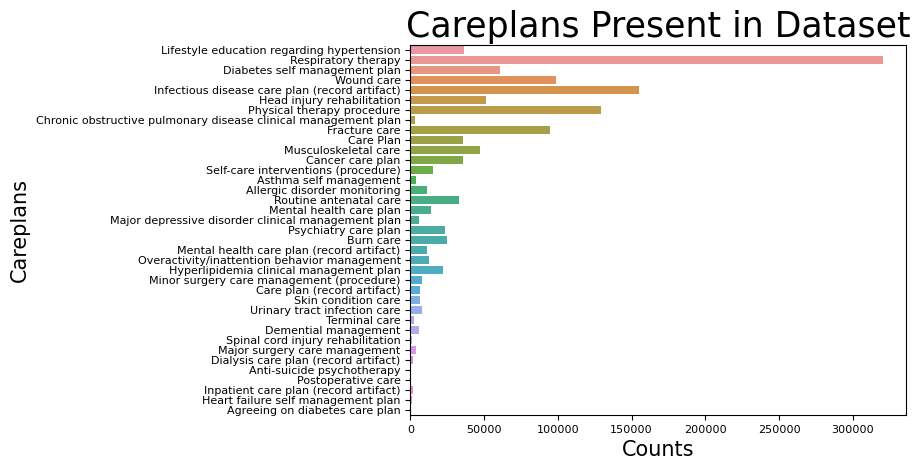

In [47]:
b = sns.countplot(data=df_careplans,y='DESCRIPTION')
b.axes.set_title("Careplans Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Careplans",fontsize=15)
b.tick_params(labelsize=8)
plt.show()

AttributeError: 'Axes' object has no attribute 'fig'

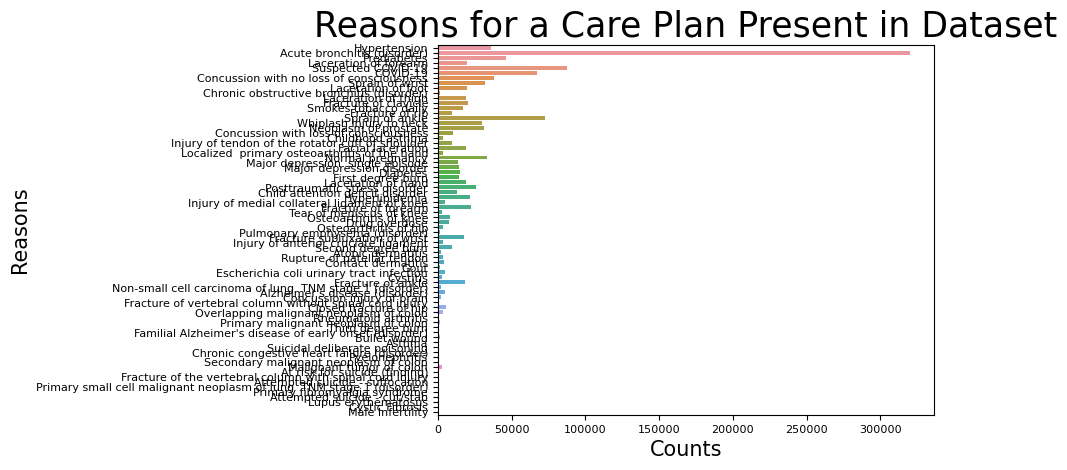

In [41]:
b = sns.countplot(data=df_careplans,y='REASONDESCRIPTION')
b.axes.set_title("Reasons for a Care Plan Present in Dataset",fontsize=25)
b.set_xlabel("Counts",fontsize=15)
b.set_ylabel("Reasons",fontsize=15)
b.tick_params(labelsize=8)
b.fig.set_figheight(6)
plt.show()

In [64]:
df_conditions

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1957-09-20,1957-10-01,55f07b08-3c77-42cc-8514-4c0a37c4039e,6f777c09-97ea-4415-b745-76ab5a7568ac,195662009,Acute viral pharyngitis (disorder)
1,1957-12-17,1958-01-28,55f07b08-3c77-42cc-8514-4c0a37c4039e,3fc5380a-53dc-4c46-8e0c-6014a3a279cd,65363002,Otitis media
2,1961-07-16,1961-07-24,55f07b08-3c77-42cc-8514-4c0a37c4039e,f57946ec-edf4-466b-9657-729e57920f17,43878008,Streptococcal sore throat (disorder)
3,1962-01-23,1962-02-03,55f07b08-3c77-42cc-8514-4c0a37c4039e,71371290-9340-4c82-b58f-f10433f5cb94,195662009,Acute viral pharyngitis (disorder)
4,1964-09-22,1964-10-05,55f07b08-3c77-42cc-8514-4c0a37c4039e,f707e04f-83f5-4251-8d16-7c551b3e8468,195662009,Acute viral pharyngitis (disorder)
...,...,...,...,...,...,...
3672059,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,43724002,Chill (finding)
3672060,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,386661006,Fever (finding)
3672061,2020-03-11,2020-03-25,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,36955009,Loss of taste (finding)
3672062,2020-03-11,2020-03-11,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,46911c7e-045a-42b4-ae9f-645377e60864,840544004,Suspected COVID-19


In [65]:
df_devices

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,UDI
0,2019-11-16T21:13:01Z,NaN,5fce809a-f069-4ff3-a68c-76942da03278,9328ed28-eb36-44c0-a1ff-c38b433dec69,706004007,Implantable cardiac pacemaker (physical object),(01)11599848534981(11)191026(17)441109(10)1530...
1,1996-07-25T21:02:59Z,NaN,3da0bed0-f4ee-41d8-8cde-895a52bea26e,92352b1c-b755-4e51-ae99-9ecbc9b1814c,706004007,Implantable cardiac pacemaker (physical object),(01)71250478160806(11)960704(17)210719(10)3726...
2,2012-01-01T21:07:49Z,NaN,fd8630cd-4ba5-4617-ad31-2cd5202ae186,4d03aeab-f673-485b-91a4-31f8af7ef7ae,72506001,Implantable defibrillator device (physical ob...,(01)12817452729914(11)111211(17)361225(10)2777...
3,1974-12-06T18:30:47Z,NaN,993fb5d0-db7b-4b8e-8491-a8786f833e44,38637d2d-4a51-4ee5-b176-f65a148f0423,72506001,Implantable defibrillator device (physical ob...,(01)27866115517464(11)741115(17)991130(10)1007...
4,2017-10-04T16:09:05Z,NaN,dbc68a08-5421-4421-a89b-bbc60e4e1269,aead11a7-9135-4869-a7e0-ef6f4e88d26b,72506001,Implantable defibrillator device (physical ob...,(01)33659393087823(11)170913(17)420928(10)6757...
...,...,...,...,...,...,...,...
9179,2012-06-14T18:56:52Z,NaN,ab736ea2-d60a-474d-9e20-17ca72d3370d,bbb3bcef-4869-497d-99d7-603acd2fb79d,706004007,Implantable cardiac pacemaker (physical object),(01)42292037075012(11)120524(17)370608(10)3610...
9180,1973-02-28T00:02:48Z,NaN,cccddcc8-4bbf-4ea4-a466-271dcdf07246,b1762414-79d8-444b-8462-c7ef8dc60ea5,72506001,Implantable defibrillator device (physical ob...,(01)36722796092159(11)730206(17)980221(10)1463...
9181,2006-01-08T10:25:12Z,NaN,4bb5af1b-114e-4762-b21e-c2c162981b22,f7b4ee41-6042-4172-a0f4-259ca388b55e,705643001,Coronary artery stent (physical object),(01)29899286445004(11)051218(17)310102(10)1385...
9182,2013-02-11T08:32:17Z,NaN,3ae01835-3c24-48cb-84d6-0a5e130f1e7c,414030cd-670b-4082-8498-6b470120b3f3,706004007,Implantable cardiac pacemaker (physical object),(01)20597026163127(11)130121(17)380205(10)3256...


In [66]:
df_encounters

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,c4a23506-81ac-454d-93a7-e41eee8ee92b,1957-05-21T20:39:45Z,1957-05-21T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
1,ef7eb530-8aa2-4b7a-8a20-51e0fe94ce98,1957-06-25T20:39:45Z,1957-06-25T21:09:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
2,edc1b81b-6c66-45ee-ace6-893f4b7f15ee,1957-08-27T20:39:45Z,1957-08-27T21:09:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
3,6f777c09-97ea-4415-b745-76ab5a7568ac,1957-09-20T20:39:45Z,1957-09-20T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,1ef2c91d-c01a-396c-80a8-4c1982295946,0c54d0ea-ffe7-3347-9d30-860164fa689f,d47b3510-2895-3b70-9897-342d681c769d,ambulatory,185345009,Encounter for symptom,89.01,89.01,9.01,195662009.0,Acute viral pharyngitis (disorder)
4,94163934-71eb-4d94-98f5-a576453688c5,1957-10-29T20:39:45Z,1957-10-29T20:54:45Z,55f07b08-3c77-42cc-8514-4c0a37c4039e,dd5334a7-972e-30b1-b537-7767769efcef,cae319fe-9fcc-394e-80e5-bc9a8a7f6c54,d47b3510-2895-3b70-9897-342d681c769d,wellness,410620009,Well child visit (procedure),89.01,89.01,9.01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20882420,3df10d41-9c85-4290-9bbb-7db2f0ae4bb5,2017-08-07T02:26:03Z,2017-08-07T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882421,f36bf471-2904-4cbb-87fd-7c8ef79f225a,2018-08-13T02:26:03Z,2018-08-13T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882422,4f237f52-768d-4ffa-a7e0-8bdd7056bd20,2019-08-19T02:26:03Z,2019-08-19T02:56:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,wellness,162673000,General examination of patient (procedure),125.00,125.00,125.00,NaN,NaN
20882423,46911c7e-045a-42b4-ae9f-645377e60864,2020-03-12T02:26:03Z,2020-03-12T03:52:03Z,3d424c3f-4fde-4af2-a3eb-e8a3d09e531a,4b3fa477-bc25-370b-b252-92cdb6dfad1e,ed70ec29-f2a6-3c2a-a5c5-8403c48254d2,7caa7254-5050-3b5e-9eae-bd5ea30e809c,ambulatory,185345009,Encounter for symptom (procedure),125.00,125.00,85.00,NaN,NaN


In [96]:
# compile the list of dataframes I want to merge
data_frames = [
    df_allergies, df_careplans, df_conditions, df_devices, df_encounters,df_imaging_studies,
    df_immunizations,df_medications, df_observations, df_organizations, df_patients, df_payers, df_payer_transitions,
    df_procedures, df_providers, df_supplies
    
]

In [14]:
new_df = pd.merge(df_allergies, df_careplans, on='PATIENT',how='outer')
new_df = pd.merge(new_df, df_conditions, on='PATIENT',how='outer')
new_df = pd.merge(new_df, df_devices, on='PATIENT',how='outer')

new_df

MemoryError: Unable to allocate 1.96 GiB for an array with shape (4, 65926615) and data type object

In [10]:
new_df = pd.merge(df_allergies, df_careplans, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_conditions, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_devices, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_encounters, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_imaging_studies, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_immunizations, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_medications, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_observations, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_organizations, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_patients, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_payers, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_payer_transitions, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_procedures, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_providers, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_supplies, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df

C:\Users\vmurc\AppData\Local\Temp\ipykernel_32912\4037457743.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'CODE_x', 'STOP_x', 'ENCOUNTER_x', 'DESCRIPTION_x', 'START_x'} in the result is deprecated and will raise a MergeError in a future version.
  new_df = pd.merge(new_df, df_devices, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
C:\Users\vmurc\AppData\Local\Temp\ipykernel_32912\4037457743.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ENCOUNTER_x', 'DESCRIPTION_x', 'CODE_x'} in the result is deprecated and will raise a MergeError in a future version.
  new_df = pd.merge(new_df, df_immunizations, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
C:\Users\vmurc\AppData\Local\Temp\ipykernel_32912\4037457743.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'START_x', 'STOP_x'} in the result is deprecated and will raise a MergeError in a future 

KeyError: 'PATIENT'

In [57]:
new_df = pd.merge(df_careplans, df_allergies, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df = pd.merge(new_df, df_observations, on='PATIENT',how='inner').drop_duplicates(subset=['PATIENT']).reset_index(drop=True)
new_df

,Id,START_x,STOP_x,PATIENT,ENCOUNTER_x,CODE_x,DESCRIPTION_x,REASONCODE,REASONDESCRIPTION,START_y,...,ENCOUNTER_y,CODE_y,DESCRIPTION_y,DATE,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,a41f12f5-f1db-4414-b1cf-f75dbaf48ade,1952-05-17,NaN,bb415c7b-8428-43ea-954e-de034d98d43e,74deed8c-f32f-486a-bae6-b7e71577603d,384758001,Self-care interventions (procedure),NaN,NaN,1952-06-01,...,494ed6b0-4c29-44c9-88ca-fdae30be8fb6,300916003,Latex allergy,1951-05-23T19:07:03Z,191c823b-fd8e-495d-8a3c-a016370fb9c4,8302-2,Body Height,55.3,cm,numeric
1,f7b0b8d1-0576-41b6-9647-72e3a99d6fb6,1957-12-10,NaN,bf8efbc2-8458-4fa2-bc56-6b6ae7bd4c8e,7870ec63-8430-4c77-b5cf-1e89d30dd5d1,384758001,Self-care interventions (procedure),NaN,NaN,1957-12-29,...,cc5c58a3-7a73-42bc-93e7-8a30cee19a92,91934008,Allergy to nut,1957-01-14T20:21:09Z,125557cc-07e3-4d74-9770-0674cf1b9dc7,8302-2,Body Height,53.8,cm,numeric
2,da8b4f39-233a-4ae8-90d9-ad7b4681ed6a,1990-12-31,NaN,6292eaf6-65e1-48d1-874c-79bbb397aa9e,17fe90c9-45b0-4644-b6da-bae17935f2fc,384758001,Self-care interventions (procedure),NaN,NaN,1991-01-18,...,f4d2fbaf-1ec3-4704-bf96-23a4af5e97fd,419474003,Allergy to mould,1989-10-07T09:12:41Z,25a0b30a-2698-41c5-9d47-3eb81b5579b9,8302-2,Body Height,48.3,cm,numeric
3,b4b8f986-26e5-49d4-ac69-f9b1db97149a,1935-06-15,NaN,7f309ccd-aa42-4f70-8bf1-1c00b202c8e9,749e08e7-633d-413d-8d8a-d70d4e6ec974,384758001,Self-care interventions (procedure),NaN,NaN,1935-06-25,...,1d10a9bc-1152-43e1-bee9-edb47f535cec,419474003,Allergy to mould,1934-04-21T04:37:00Z,31a2e93e-d1e3-40eb-9983-50a77d4268a1,8302-2,Body Height,55.8,cm,numeric
4,07c49057-40c6-4c3c-b578-55e64066709d,1964-12-28,NaN,083a8107-cf5c-4de6-b763-0aced59e4915,ce8c8f5f-9b1c-438d-9831-2525b87dea8b,384758001,Self-care interventions (procedure),NaN,NaN,1965-01-07,...,087a9ce9-acca-4e3e-ae33-c5b8e1c84c02,419474003,Allergy to mould,1964-07-01T13:30:26Z,23594791-9190-48dc-85ce-e2354fc84301,8302-2,Body Height,54.0,cm,numeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,d221959d-cd2a-41fe-96e4-49f2eb710bbd,1986-06-10,NaN,c25fe3a3-6686-4ce0-a1d1-1782a1ce8a01,24b761e8-b952-4888-91eb-e03d5c38a261,384758001,Self-care interventions (procedure),NaN,NaN,1986-06-20,...,e5e91df3-4dec-4618-8b47-86d76dce8f3c,300916003,Latex allergy,1985-11-12T14:14:08Z,93ab0e74-e9ff-4463-a867-32dc8ca0f5d3,8302-2,Body Height,52.2,cm,numeric
534,fb713780-bfc8-48fd-88fa-48663ae32ef4,1932-10-21,NaN,fdd81b4e-37e5-452f-b421-8c85be768c63,ba11dc71-e732-408a-8d5b-5cf8e3b901ec,384758001,Self-care interventions (procedure),NaN,NaN,1932-11-07,...,e3945433-f6ec-4bb6-a06f-a9e5964f4292,300916003,Latex allergy,1931-10-27T23:12:37Z,d48e022e-a61e-4117-bde8-1c9d59a2ac39,8302-2,Body Height,51.5,cm,numeric
535,4fdf0149-b02c-4db7-a14e-d19af1455842,1945-08-26,1945-09-09,43d15d04-4b53-412c-ae7b-4f2aea9e03bb,d2c18362-6583-4399-a4c9-63cac2f5809d,91251008,Physical therapy procedure,44465007.0,Sprain of ankle,1945-11-04,...,12d9e16c-8998-4ccb-ba83-8c24ea014b8c,232350006,House dust mite allergy,1943-10-06T16:00:22Z,74194f79-6434-4e1e-961c-1392c1088a61,8302-2,Body Height,52.6,cm,numeric
536,75d07e18-649d-4b9b-8d5b-7d5fd1f9b4ff,1985-01-19,NaN,d13a5960-73f2-4c84-9b1c-39308e6f2b72,5b1acab4-7374-400c-add4-19712ee16874,384758001,Self-care interventions (procedure),NaN,NaN,1985-02-02,...,50d2348d-9cd1-4138-9a4f-833928cb0438,419474003,Allergy to mould,1984-05-24T05:50:09Z,9d724b9e-9a06-45a6-9d39-7fc6b8e3a314,8302-2,Body Height,54.2,cm,numeric


In [44]:
new_df['DESCRIPTION_y'].value_counts()

Allergy to mould            47842
Latex allergy               24365
Shellfish allergy           16693
Allergy to bee venom        14465
Dander (animal) allergy     13036
Allergy to grass pollen      5387
Allergy to wheat             5184
Allergy to eggs              5006
Allergy to peanuts           4952
Allergy to fish              3528
Allergy to nut               3128
House dust mite allergy      2718
Allergy to tree pollen       2428
Allergy to soya              1573
Allergy to dairy product      803
Name: DESCRIPTION_y, dtype: int64

<Axes: xlabel='count', ylabel='DESCRIPTION_y'>

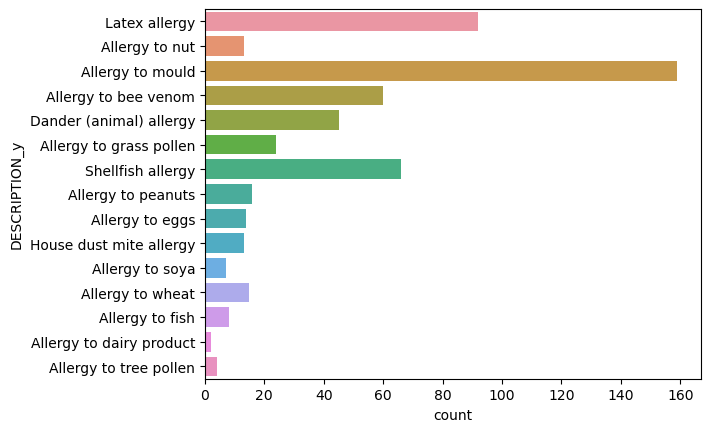

In [64]:
sns.countplot(data=new_df,y='DESCRIPTION_y')

<Axes: xlabel='count', ylabel='DESCRIPTION_x'>

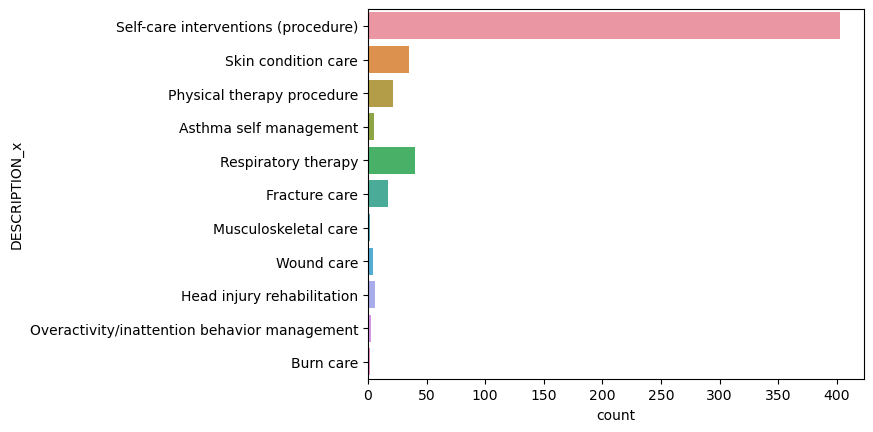

In [66]:
sns.countplot(data=new_df,y='DESCRIPTION_x')

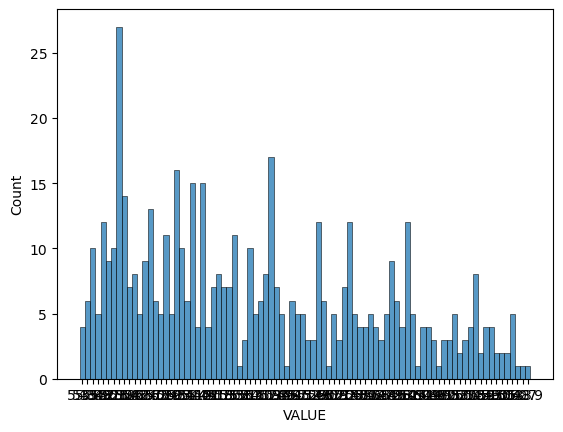

In [93]:
sns.histplot(data=new_df,x='VALUE',bins=10)
plt.show()

<Axes: xlabel='count', ylabel='REASONDESCRIPTION'>

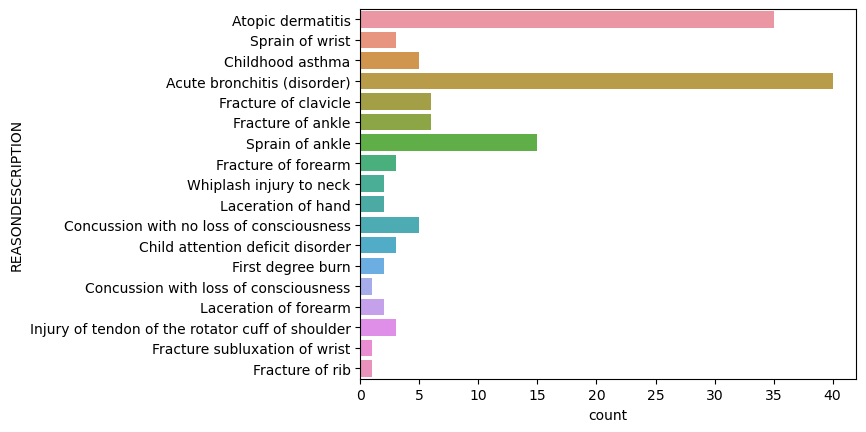

In [68]:
sns.countplot(data=new_df,y='REASONDESCRIPTION')